In [1]:
import itertools
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.feature_selection import mutual_info_classif as MIF
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler, SVMSMOTE, KMeansSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import random
import os
# chain()可以把一组迭代对象串联起来，形成一个更大的迭代器
from itertools import chain
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers, layers, losses, metrics
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, Lambda, multiply
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

from deepctr.inputs import get_dense_input, create_embedding_matrix, embedding_lookup, get_dense_input, varlen_embedding_lookup, \
    get_varlen_pooling_list, mergeDict
from deepctr.layers.sequence import SequencePoolingLayer

from deepctr.feature_column import  SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names, build_input_features, get_linear_logit, DEFAULT_GROUP_NAME, input_from_feature_columns
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.interaction import FM, FEFMLayer, BiInteractionPooling, AFMLayer, CIN, InteractingLayer, FwFMLayer, InnerProductLayer, OutterProductLayer
from deepctr.layers.utils import concat_func, add_func, Hash, NoMask, combined_dnn_input, reduce_sum, softmax
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import Zeros, glorot_normal, RandomNormal
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 12
np.random.seed(1024) # seed是一个固定的整数即可
random.seed(1024)
os.environ['PYTHONHASHSEED'] = str(1024)

In [2]:
data = pd.read_csv('E:/BaiduNetdiskDownload/论文/论文/medmnist/healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
data = data.drop('id', axis = 1)

In [7]:
data=data.drop(data[data.gender=='Other'].index,axis=0).dropna()

In [8]:
encoder = OrdinalEncoder()
data.loc[:, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = encoder.fit_transform(data[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
# imputer = SimpleImputer(strategy = 'mean')
# data.loc[:, 'bmi'] = imputer.fit_transform(data.loc[:, 'bmi'].values.reshape(-1, 1))

In [9]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
data.dtypes

gender               float64
age                  float64
hypertension           int64
heart_disease          int64
ever_married         float64
work_type            float64
Residence_type       float64
avg_glucose_level    float64
bmi                  float64
smoking_status       float64
stroke                 int64
dtype: object

In [11]:
data.shape

(4908, 11)

In [12]:
for i in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']:
    data.loc[:, i] = data.loc[:, i].astype('int32')

In [13]:
for i in ['age', 'avg_glucose_level', 'bmi']:
    data.loc[:, i] = data.loc[:, i].astype('float32')

In [14]:
data.dtypes

gender                 int32
age                  float32
hypertension           int32
heart_disease          int32
ever_married           int32
work_type              int32
Residence_type         int32
avg_glucose_level    float32
bmi                  float32
smoking_status         int32
stroke                 int32
dtype: object

In [15]:
data1 = data.drop(columns=['stroke'])
labe = data['stroke']
dat, test, lab, label1 = train_test_split(data1, labe, test_size = 0.2, stratify=labe)
# dat, test, lab, label1 = train_test_split(data1, labe, test_size = 0.2)

In [16]:
dat = dat.reset_index(drop = True)
lab = lab.reset_index(drop = True)

In [17]:
dat

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,34.0,0,0,1,2,1,80.809998,33.200001,2
1,0,65.0,0,0,1,0,1,82.720001,29.799999,3
2,0,49.0,0,0,1,2,0,114.760002,24.700001,2
3,0,45.0,0,0,1,2,0,218.100006,55.000000,3
4,0,38.0,0,0,1,2,0,100.050003,20.799999,3
...,...,...,...,...,...,...,...,...,...,...
3921,1,6.0,0,0,0,4,1,55.610001,19.600000,0
3922,1,74.0,0,0,1,2,1,72.959999,31.299999,3
3923,0,35.0,0,0,1,2,0,58.720001,40.000000,3
3924,0,54.0,0,0,1,2,1,207.789993,38.599998,2


In [18]:
lab

0       0
1       0
2       0
3       0
4       0
       ..
3921    0
3922    1
3923    0
3924    0
3925    0
Name: stroke, Length: 3926, dtype: int32

In [19]:
# sm = RandomUnderSampler(random_state=42)
# sm = SMOTEENN(random_state=42)
# sm = KMeansSMOTE(random_state=42)
# sm = SVMSMOTE(random_state=42)
# sm = RandomOverSampler(random_state=42)
# sm = ADASYN(random_state=42)
sm = BorderlineSMOTE(random_state=42,kind="borderline-2")
# sm =  SMOTETomek(random_state=42) #实例化
# sm = SMOTE(random_state=42)
dat, lab = sm.fit_sample(dat,lab)

In [20]:
train = pd.concat((dat, lab), axis = 1)
train = shuffle(train)
train = train.reset_index(drop = True)

In [21]:
# clf = OneClassSVM(kernel="rbf")
# clf = clf.fit(train)
# y_pred = clf.predict(train)
# y_pred=np.array([1 if x == 1 else 0 for x in y_pred])
# y_pred[y_pred == 1].sum()
clf = IsolationForest(n_estimators=100)
clf = clf.fit(train)
y_pred = clf.predict(train)
y_pred=np.array([1 if x == 1 else 0 for x in y_pred])
y_pred[y_pred == 1].sum()

4082

In [22]:
np.array(y_pred == lab).sum()

3705

In [23]:
# train = train[y_pred == lab]
# train.shape

In [24]:
dat = train.drop(columns=['stroke'])
lab = train['stroke']
result = MIF(dat, lab)
dat.columns[result <= 0]

Index(['ever_married'], dtype='object')

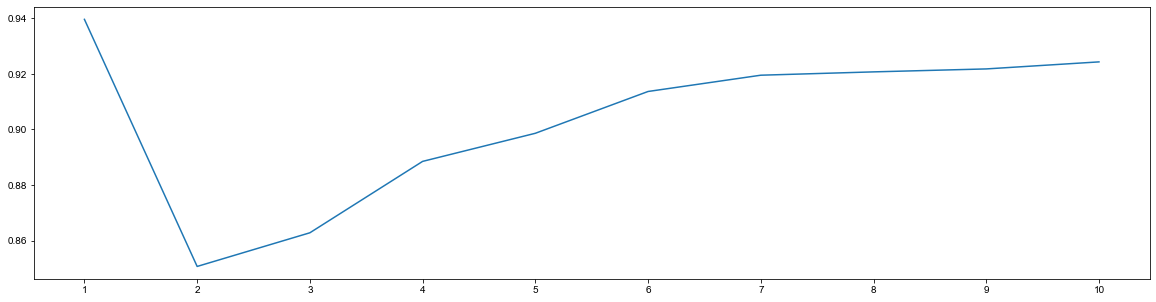

In [25]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
RFC_ = RFC(n_estimators =10,random_state=0)
score = []
for i in range(1,11,1):
    X_wrapper = RFE(RFC_,n_features_to_select=i, step=1).fit_transform(dat,lab)
    once = cross_val_score(RFC_,X_wrapper,lab,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,11,1),score)
plt.xticks(range(1,11,1))
plt.show()

In [26]:
data_train = train.copy()
# data_test = test.copy()
train = data_train.drop(columns=['stroke'])
label = data_train['stroke']
# test = data_test.drop(columns=['stroke'])
# label1 = data_test['stroke']

In [27]:
np.array(label1 == 1).sum()

42

In [28]:
train.shape[0],test.shape[0]

(7517, 982)

In [29]:
data = train.append(test)
dense_features=['age', 'avg_glucose_level', 'bmi']
sparse_features = list(set(data.columns.tolist()).difference(set(dense_features)))

# 离散型数据进行标签化处理
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
# 连续型数据进行归一化处理，使其范围在（0，1）
mms = StandardScaler()
# mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                        for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 3.generate input deepfm_data for model
# train, test = train_test_split(deepfm_data, test_size=0.2)

deepfm_train = data.head(train.shape[0])
deepfm_test = data.tail(test.shape[0])

deepfm_train = {name:deepfm_train[name] for name in feature_names}
deepfm_test = {name:deepfm_test[name] for name in feature_names}

In [30]:
# def PNN2(dnn_feature_columns, dnn_hidden_units=(256, 128, 64), l2_reg_embedding=0.00001, l2_reg_dnn=0,
#         seed=1024, dnn_dropout=0, dnn_activation='relu', use_inner=True, use_outter=False, kernel_type='mat',
#         task='binary'):
#     if kernel_type not in ['mat', 'vec', 'num']:
#         raise ValueError("kernel_type must be mat,vec or num")

#     features = build_input_features(dnn_feature_columns)

#     inputs_list = list(features.values())

#     sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
#                                                                          l2_reg_embedding, seed)
#     inner_product = tf.keras.layers.Flatten()(
#         InnerProductLayer()(sparse_embedding_list))
#     outter_product = OutterProductLayer(kernel_type)(sparse_embedding_list)

#     # ipnn deep input
#     linear_signal = tf.keras.layers.Reshape(
#         [sum(map(lambda x: int(x.shape[-1]), sparse_embedding_list))])(concat_func(sparse_embedding_list))

#     if use_inner and use_outter:
#         deep_input = tf.keras.layers.Concatenate()(
#             [linear_signal, inner_product, outter_product])
#     elif use_inner:
#         deep_input = tf.keras.layers.Concatenate()(
#             [linear_signal, inner_product])
#     elif use_outter:
#         deep_input = tf.keras.layers.Concatenate()(
#             [linear_signal, outter_product])
#     else:
#         deep_input = linear_signal

#     dnn_input = combined_dnn_input([deep_input], dense_value_list)
#     dnn_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, False, seed=seed)(dnn_input)
#     dnn_logit = tf.keras.layers.Dense(
#         1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_out)

#     output = PredictionLayer(task)(dnn_logit)

#     model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#             loss=losses.BinaryCrossentropy(), 
#             metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#     return model

In [31]:
def input_from_feature_columns(features, feature_columns, l2_reg, seed, prefix='', seq_mask_zero=True,
                               support_dense=True, support_group=False):
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []

    embedding_matrix_dict = create_embedding_matrix(feature_columns, l2_reg, seed, prefix=prefix,
                                                    seq_mask_zero=seq_mask_zero)
    group_sparse_embedding_dict = embedding_lookup(embedding_matrix_dict, features, sparse_feature_columns)
    dense_value_list = get_dense_input(features, feature_columns)
    if not support_dense and len(dense_value_list) > 0:
        raise ValueError("DenseFeat is not supported in dnn_feature_columns")

    sequence_embed_dict = varlen_embedding_lookup(embedding_matrix_dict, features, varlen_sparse_feature_columns)
    group_varlen_sparse_embedding_dict = get_varlen_pooling_list(sequence_embed_dict, features,
                                                                 varlen_sparse_feature_columns)
    group_embedding_dict = mergeDict(group_sparse_embedding_dict, group_varlen_sparse_embedding_dict)
#     if not support_group:
#         group_embedding_dict = list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict, dense_value_list

In [32]:
# def DIFM(linear_feature_columns, dnn_feature_columns,
#          att_embedding_size=8, att_head_num=8, att_res=True, dnn_hidden_units=(256, 128, 64),
#          l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
#          dnn_activation='relu', dnn_use_bn=False, task='binary'):
#     if not len(dnn_hidden_units) > 0:
#         raise ValueError("dnn_hidden_units is null!")

#     features = build_input_features(
#         linear_feature_columns + dnn_feature_columns)

#     sparse_feat_num = len(list(filter(lambda x: isinstance(x, SparseFeat) or isinstance(x, VarLenSparseFeat),
#                                       dnn_feature_columns)))
#     inputs_list = list(features.values())

#     sparse_embedding_list, _ = input_from_feature_columns(features, dnn_feature_columns,
#                                                           l2_reg_embedding, seed)

#     if not len(sparse_embedding_list) > 0:
#         raise ValueError("there are no sparse features")

#     att_input = concat_func(sparse_embedding_list, axis=1)
#     att_out = InteractingLayer(att_embedding_size, att_head_num, att_res, scaling=True)(att_input)
#     att_out = tf.keras.layers.Flatten()(att_out)
#     m_vec = tf.keras.layers.Dense(
#         sparse_feat_num, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed=seed))(att_out)

#     dnn_input = combined_dnn_input(sparse_embedding_list, [])
#     dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
#     m_bit = tf.keras.layers.Dense(
#         sparse_feat_num, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed=seed))(dnn_output)

#     input_aware_factor = add_func([m_vec, m_bit])  # the complete input-aware factor m_x

#     linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
#                                     l2_reg=l2_reg_linear, sparse_feat_refine_weight=input_aware_factor)

#     fm_input = concat_func(sparse_embedding_list, axis=1)
#     refined_fm_input = tf.keras.layers.Lambda(lambda x: x[0] * tf.expand_dims(x[1], axis=-1))(
#         [fm_input, input_aware_factor])
#     fm_logit = FM()(refined_fm_input)

#     final_logit = add_func([linear_logit, fm_logit])

#     output = PredictionLayer(task)(final_logit)
#     model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#             loss=losses.BinaryCrossentropy(), 
#             metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#     return model

In [33]:
# def DeepFEFM(linear_feature_columns, dnn_feature_columns, use_fefm=True,
#              dnn_hidden_units=(256, 128, 64), l2_reg_linear=0.00001, l2_reg_embedding_feat=0.00001,
#              l2_reg_embedding_field=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0.0,
#              exclude_feature_embed_in_dnn=False,
#              use_linear=True, use_fefm_embed_in_dnn=True, dnn_activation='relu', dnn_use_bn=False, task='binary'):
#     features = build_input_features(linear_feature_columns + dnn_feature_columns)

#     inputs_list = list(features.values())

#     linear_logit = get_linear_logit(features, linear_feature_columns, l2_reg=l2_reg_linear, seed=seed, prefix='linear')

#     group_embedding_dict, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
#                                                                         l2_reg_embedding_feat,
#                                                                         seed, support_group=True)

#     fefm_interaction_embedding = concat_func([FEFMLayer(
#         regularizer=l2_reg_embedding_field)(concat_func(v, axis=1))
#                                               for k, v in group_embedding_dict.items() if k in [DEFAULT_GROUP_NAME]],
#                                              axis=1)

#     dnn_input = combined_dnn_input(list(chain.from_iterable(group_embedding_dict.values())), dense_value_list)

#     # if use_fefm_embed_in_dnn is set to False it is Ablation4 (Use false only for Ablation)
#     if use_fefm_embed_in_dnn:
#         if exclude_feature_embed_in_dnn:
#             # Ablation3: remove feature vector embeddings from the DNN input
#             dnn_input = fefm_interaction_embedding
#         else:
#             # No ablation
#             dnn_input = concat_func([dnn_input, fefm_interaction_embedding], axis=1)

#     dnn_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)

#     dnn_logit = tf.keras.layers.Dense(
#         1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_out)

#     fefm_logit = tf.keras.layers.Lambda(lambda x: reduce_sum(x, axis=1, keep_dims=True))(fefm_interaction_embedding)

#     if len(dnn_hidden_units) == 0 and use_fefm is False and use_linear is True:  # only linear
#         final_logit = linear_logit
#     elif len(dnn_hidden_units) == 0 and use_fefm is True and use_linear is True:  # linear + FEFM
#         final_logit = tf.keras.layers.add([linear_logit, fefm_logit])
#     elif len(dnn_hidden_units) > 0 and use_fefm is False and use_linear is True:  # linear +　Deep # Ablation1
#         final_logit = tf.keras.layers.add([linear_logit, dnn_logit])
#     elif len(dnn_hidden_units) > 0 and use_fefm is True and use_linear is True:  # linear + FEFM + Deep
#         final_logit = tf.keras.layers.add([linear_logit, fefm_logit, dnn_logit])
#     elif len(dnn_hidden_units) == 0 and use_fefm is True and use_linear is False:  # only FEFM (shallow)
#         final_logit = fefm_logit
#     elif len(dnn_hidden_units) > 0 and use_fefm is False and use_linear is False:  # only Deep
#         final_logit = dnn_logit
#     elif len(dnn_hidden_units) > 0 and use_fefm is True and use_linear is False:  # FEFM + Deep # Ablation2
#         final_logit = tf.keras.layers.add([fefm_logit, dnn_logit])
#     else:
#         raise NotImplementedError

#     output = PredictionLayer(task)(final_logit)
#     model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#                loss=losses.BinaryCrossentropy(), 
#                metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#     return model

In [34]:
# def NFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 128, 64),
#         l2_reg_embedding=1e-5, l2_reg_linear=1e-5, l2_reg_dnn=0, seed=1024, bi_dropout=0,
#         dnn_dropout=0, dnn_activation='relu', task='binary'):
#     features = build_input_features(linear_feature_columns + dnn_feature_columns)

#     inputs_list = list(features.values())

#     linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
#                                     l2_reg=l2_reg_linear)

#     sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
#                                                                          l2_reg_embedding, seed)

#     fm_input = concat_func(sparse_embedding_list, axis=1)
#     bi_out = BiInteractionPooling()(fm_input)
#     if bi_dropout:
#         bi_out = tf.keras.layers.Dropout(bi_dropout)(bi_out, training=None)
#     dnn_input = combined_dnn_input([bi_out], dense_value_list)
#     dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, False, seed=seed)(dnn_input)
#     dnn_logit = tf.keras.layers.Dense(
#         1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_output)

#     final_logit = add_func([linear_logit, dnn_logit])

#     output = PredictionLayer(task)(final_logit)

#     model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#             loss=losses.BinaryCrossentropy(), 
#             metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#     return model

In [35]:
# def AFM(linear_feature_columns, dnn_feature_columns, fm_group=DEFAULT_GROUP_NAME, use_attention=True,
#         attention_factor=8,l2_reg_linear=1e-5, l2_reg_embedding=1e-5, l2_reg_att=1e-5, afm_dropout=0, seed=1024,
#         task='binary'):
#     features = build_input_features(linear_feature_columns + dnn_feature_columns)

#     inputs_list = list(features.values())

#     group_embedding_dict, _ = input_from_feature_columns(features, dnn_feature_columns, l2_reg_embedding,
#                                                          seed, support_dense=True, support_group=True)

#     linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
#                                     l2_reg=l2_reg_linear)

#     if use_attention:
#         fm_logit = add_func([AFMLayer(attention_factor, l2_reg_att, afm_dropout,
#                                       seed)(list(v)) for k, v in group_embedding_dict.items() if k in fm_group])
#     else:
#         fm_logit = add_func([FM()(concat_func(v, axis=1))
#                              for k, v in group_embedding_dict.items() if k in fm_group])

#     final_logit = add_func([linear_logit, fm_logit])
#     output = PredictionLayer(task)(final_logit)

#     model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#                loss=losses.BinaryCrossentropy(), 
#                metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#     return model

In [133]:
def class_balanced_sigmoid_cross_entropy(label, logits):
    y = tf.cast(label, tf.float32)
    logits = tf.cast(logits, tf.float32)
    count_neg = tf.reduce_sum(1. - y) # the number of 0 in y
    count_pos = tf.reduce_sum(y) # the number of 1 in y (less than count_neg)
    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(y, logits, pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta))
    return cost
def PNN(linear_feature_columns, dnn_feature_columns, fm_group=[DEFAULT_GROUP_NAME], dnn_hidden_units=(256, 128, 64), 
        l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, l2_reg_att=2.1, attention_factor=4, 
        afm_dropout=0.8, seed=1024, dnn_dropout=0, dnn_activation='relu', use_inner=True, use_outter=False, 
        kernel_type='mat',task='binary'):
    if kernel_type not in ['mat', 'vec', 'num']:
        raise ValueError("kernel_type must be mat,vec or num")

    features = build_input_features(dnn_feature_columns)

    inputs_list = list(features.values())

    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
                                    l2_reg=l2_reg_linear)
    group_embedding_dict, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)
    sparse_embedding_list = list(chain.from_iterable(group_embedding_dict.values()))
    fm_logit = add_func([FM()(concat_func(v, axis=1)) 
                         for k, v in group_embedding_dict.items() if k in fm_group])
    afm_logit = add_func([AFMLayer(attention_factor, l2_reg_att, afm_dropout,
                                    seed)(list(v)) for k, v in group_embedding_dict.items() if k in fm_group])
    inner_product = tf.keras.layers.Flatten()(
        InnerProductLayer()(sparse_embedding_list))
    outter_product = OutterProductLayer(kernel_type)(sparse_embedding_list)

    # ipnn deep input
    linear_signal = tf.keras.layers.Reshape(
        [sum(map(lambda x: int(x.shape[-1]), sparse_embedding_list))])(concat_func(sparse_embedding_list))

    if use_inner and use_outter:
        deep_input = tf.keras.layers.Concatenate()(
            [linear_signal, inner_product, outter_product])
    elif use_inner:
        deep_input = tf.keras.layers.Concatenate()(
            [linear_signal, inner_product])
    elif use_outter:
        deep_input = tf.keras.layers.Concatenate()(
            [linear_signal, outter_product])
    else:
        deep_input = linear_signal

    dnn_input = combined_dnn_input([deep_input], dense_value_list)
    dnn_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, False, seed=seed)(dnn_input)
    dnn_out = tf.keras.layers.BatchNormalization()(dnn_out)
    dnn_out = tf.keras.layers.Dense(
        64, activation = 'relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_out)
    dnn_out = tf.keras.layers.BatchNormalization()(dnn_out)
    dnn_logit = tf.keras.layers.Dense(
        1, use_bias=False, kernel_initializer=tf.keras.initializers.glorot_normal(seed))(dnn_out)
    final_logit = add_func([fm_logit, dnn_logit])
    output = PredictionLayer(task)(final_logit)

    model = tf.keras.models.Model(inputs=inputs_list, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
            loss=losses.BinaryCrossentropy(),
            metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
    return model

In [134]:
# def focal_loss(gamma=2., alpha=0.25):
 
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         loss = -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(1e-07+pt_1)) \
#            -tf.reduce_sum((1-alpha) * tf.pow( pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-07))
#         return loss
#     return focal_loss_fixed
# def M(linear_feature_columns, dnn_feature_columns, fm_group=[DEFAULT_GROUP_NAME], dnn_hidden_units=(128, 128),
#       l2_reg_linear=0.00001, lr = 0.001, l2_reg_embedding=0.00001, l2_reg_dnn=0, 
#       seed=0, dnn_dropout=0,dropout = 0.1, dnn_activation='relu', dnn_use_bn=False, task='binary'):
#             # deepFM处理过程
#             features = build_input_features(linear_feature_columns + dnn_feature_columns)

#             inputs_list = list(features.values())

#             linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
#                                     l2_reg=l2_reg_linear, )
#             group_embedding_dict, dense_value_list = input_from_feature_columns(features, dnn_feature_columns, l2_reg_embedding,
#                                                                         seed = seed, support_group=True)
#             fm_logit = add_func([FM()(concat_func(v, axis=1))
#                          for k, v in group_embedding_dict.items() if k in fm_group])

#             dnn_input = combined_dnn_input(list(chain.from_iterable(
#                     group_embedding_dict.values())), dense_value_list)

#             dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout,
#                      dnn_use_bn, seed = seed)(dnn_input)
#             dnn_output=tf.keras.layers.Dropout(dropout, seed = seed)(dnn_output)
# #             dnn_output = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer=glorot_normal(seed=0), 
# #                                    kernel_regularizer = tf.keras.regularizers.l2(reg))(dnn_output)
# #             dnn_output = tf.keras.layers.Dense(
# #                     128, activation ='relu', kernel_initializer=he_normal(seed=seed))(dnn_output)
# #             dnn_output = tf.keras.layers.Dense(
# #                     128, activation ='relu', kernel_initializer=he_normal(seed=seed))(dnn_output)
# #             dnn_output = tf.keras.layers.Dense(
# #                     128, activation='relu', kernel_initializer=he_normal(seed=seed))(dnn_output)
            
# #             linear_logit = tf.keras.layers.Dense(
# #                     1, activation ='relu', kernel_initializer=he_normal(seed=seed))(linear_logit)
# #             fm_logit = tf.keras.layers.Dense(
# #                     1, activation ='relu', kernel_initializer=he_normal(seed=seed))(fm_logit)
#             dnn_logit = tf.keras.layers.Dense(
#                     1, use_bias=False, activation=None, kernel_initializer=glorot_normal(seed=seed))(dnn_output)
#             final_logit = add_func([linear_logit, fm_logit, dnn_logit])
#             output = PredictionLayer(task)(final_logit)
#             #tensorflow模型拟合
#             model = Model(inputs=[features], outputs=[output])
#             #multi_category_focal_loss2(alpha=0.35, gamma=2)
#             model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#                loss=losses.BinaryCrossentropy(), 
#                metrics=['AUC', 'binary_accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TruePositives', 'TrueNegatives', 'FalsePositives'])
#             return model

In [141]:
loslist = []
acclist = []
lrs = [1]
for i in lrs:
    accs = []
    los = []
    acces = []
    for j in range(5):
#         model = M(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns, 
#                         dnn_hidden_units=(64, 64), l2_reg_linear=0.7, lr = 0.001 ,l2_reg_embedding=2.1, 
#                   l2_reg_dnn=0, seed=1024, dnn_dropout=0.8, 
#                   dropout = 0, dnn_activation='relu')
#         model = PNN(linear_feature_columns, dnn_feature_columns, fm_group=[DEFAULT_GROUP_NAME], 
#                     dnn_hidden_units=(128, 128, 128), l2_reg_linear=0.1, l2_reg_embedding=1.7, l2_reg_dnn=0, 
#                     l2_reg_att=0.1, attention_factor=8, afm_dropout=0, seed=1024, dnn_dropout=0.8, 
#                     dnn_activation='relu', use_inner=True, use_outter=False, kernel_type='mat', task='binary')
        model = PNN(linear_feature_columns, dnn_feature_columns, fm_group=[DEFAULT_GROUP_NAME], 
                    dnn_hidden_units=(256, 128), l2_reg_linear=0.1, l2_reg_embedding=2.7, l2_reg_dnn=0, 
                    l2_reg_att=0.00001, attention_factor=4, afm_dropout=0.8, seed=1024, dnn_dropout=0.7, 
                    dnn_activation='relu', use_inner=False, use_outter=True, kernel_type='mat',task='binary')
#         model = PNN2(dnn_feature_columns, dnn_hidden_units=(96, 96, 96), l2_reg_embedding=1.3, l2_reg_dnn=0,
#             seed=1024, dnn_dropout=0.8, dnn_activation='relu', use_inner=True, use_outter=False, 
#             kernel_type='mat')
#         model = AFM(linear_feature_columns, dnn_feature_columns, fm_group=DEFAULT_GROUP_NAME, use_attention=True,
#             attention_factor=8,l2_reg_linear=0.0001, l2_reg_embedding=0.1, l2_reg_att=0.00001, afm_dropout=0.1, seed=1024)
#         model = NFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128, 128),
#         l2_reg_embedding=0.9, l2_reg_linear=0.001, l2_reg_dnn=0, seed=1024, bi_dropout=0.4,
#         dnn_dropout=0, dnn_activation='sigmoid')
#         model =  DeepFEFM(linear_feature_columns, dnn_feature_columns, use_fefm=True,
#              dnn_hidden_units=(224, 224, 224), l2_reg_linear=0.00001, l2_reg_embedding_feat=2.1,
#              l2_reg_embedding_field=0.5, l2_reg_dnn=0, seed=1024, dnn_dropout=0.6,
#              exclude_feature_embed_in_dnn=False, use_linear=True, use_fefm_embed_in_dnn=True, 
#             dnn_activation='relu')
#         model = DIFM(linear_feature_columns, dnn_feature_columns,
#          att_embedding_size=8, att_head_num=8, att_res=True, dnn_hidden_units=(64, 64, 64),
#          l2_reg_linear=0.0001, l2_reg_embedding=2.1, l2_reg_dnn=0, seed=1024, dnn_dropout=0.9,
#          dnn_activation='tanh', dnn_use_bn=False, task='binary')
    
        input_train = deepfm_train
        model.fit(input_train,
                        label,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=128,
                        shuffle = False,
                        verbose = 1, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],)
        input_test = deepfm_test
        ans_mtx = model.predict(input_test, batch_size=100)
        loss, auc, acc, pre, rec, fn, tp, tn, fp = model.evaluate(input_test, label1)
        accs.append([auc, acc, pre, rec, fn, tp, tn, fp])
        los.append(loss)
        acces.append([auc, acc])
        # auc.append(roc_auc_score(label1, ans_mtx))
        # loss.append(log_loss(label1, ans_mtx))
        # print(max(auc))
        # print(auc)
        # print(min(loss))
        # print(loss)
    los = np.array(los)
    accs = np.array(accs)
    acces = np.array(acces)
    print(los, accs, acces)
    loslist.append(los)
    acclist.append(acces)
print(loslist, acclist)

The following Variables were used a Lambda layer's call (lambda_30), but
are not present in its tracked objects:
  <tf.Variable 'afm_layer_30/projection_p:0' shape=(4, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 1/100
47/47 [==============================] - 2s 39ms/step - loss: 0.5594 - auc: 0.7806 - binary_accuracy: 0.7078 - precision: 0.6994 - recall: 0.7424 - false_negatives: 785.0000 - true_positives: 2262.0000 - true_negatives: 1994.0000 - false_positives: 972.0000 - val_loss: 0.5101 - val_auc: 0.8682 - val_binary_accuracy: 0.8092 - val_precision: 0.7585 - val_recall: 0.8748 - val_false_negatives: 89.0000 - val_true_positives: 622.0000 - val_true_negatives: 595.0000 - val_false_positives: 198.0000
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.4861 - auc: 0.8350 - binary_accura

47/47 [==============================] - 1s 14ms/step - loss: 0.3649 - auc: 0.9212 - binary_accuracy: 0.8498 - precision: 0.8268 - recall: 0.8901 - false_negatives: 335.0000 - true_positives: 2712.0000 - true_negatives: 2398.0000 - false_positives: 568.0000 - val_loss: 0.3426 - val_auc: 0.9350 - val_binary_accuracy: 0.8557 - val_precision: 0.8356 - val_recall: 0.8650 - val_false_negatives: 96.0000 - val_true_positives: 615.0000 - val_true_negatives: 672.0000 - val_false_positives: 121.0000
Epoch 16/100
47/47 [==============================] - 1s 13ms/step - loss: 0.3577 - auc: 0.9241 - binary_accuracy: 0.8508 - precision: 0.8279 - recall: 0.8907 - false_negatives: 333.0000 - true_positives: 2714.0000 - true_negatives: 2402.0000 - false_positives: 564.0000 - val_loss: 0.3548 - val_auc: 0.9327 - val_binary_accuracy: 0.8451 - val_precision: 0.8515 - val_recall: 0.8143 - val_false_negatives: 132.0000 - val_true_positives: 579.0000 - val_true_negatives: 692.0000 - val_false_positives: 101.0

47/47 [==============================] - 1s 12ms/step - loss: 0.3362 - auc: 0.9350 - binary_accuracy: 0.8640 - precision: 0.8471 - recall: 0.8927 - false_negatives: 327.0000 - true_positives: 2720.0000 - true_negatives: 2475.0000 - false_positives: 491.0000 - val_loss: 0.3386 - val_auc: 0.9399 - val_binary_accuracy: 0.8497 - val_precision: 0.8636 - val_recall: 0.8101 - val_false_negatives: 135.0000 - val_true_positives: 576.0000 - val_true_negatives: 702.0000 - val_false_positives: 91.0000
Epoch 32/100
47/47 [==============================] - 1s 12ms/step - loss: 0.3400 - auc: 0.9324 - binary_accuracy: 0.8590 - precision: 0.8395 - recall: 0.8924 - false_negatives: 328.0000 - true_positives: 2719.0000 - true_negatives: 2446.0000 - false_positives: 520.0000 - val_loss: 0.3318 - val_auc: 0.9394 - val_binary_accuracy: 0.8590 - val_precision: 0.8490 - val_recall: 0.8537 - val_false_negatives: 104.0000 - val_true_positives: 607.0000 - val_true_negatives: 685.0000 - val_false_positives: 108.0

47/47 [==============================] - 0s 10ms/step - loss: 0.3254 - auc: 0.9376 - binary_accuracy: 0.8630 - precision: 0.8425 - recall: 0.8973 - false_negatives: 313.0000 - true_positives: 2734.0000 - true_negatives: 2455.0000 - false_positives: 511.0000 - val_loss: 0.3226 - val_auc: 0.9417 - val_binary_accuracy: 0.8677 - val_precision: 0.8536 - val_recall: 0.8692 - val_false_negatives: 93.0000 - val_true_positives: 618.0000 - val_true_negatives: 687.0000 - val_false_positives: 106.0000
Epoch 48/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3252 - auc: 0.9392 - binary_accuracy: 0.8665 - precision: 0.8484 - recall: 0.8966 - false_negatives: 315.0000 - true_positives: 2732.0000 - true_negatives: 2478.0000 - false_positives: 488.0000 - val_loss: 0.3217 - val_auc: 0.9423 - val_binary_accuracy: 0.8624 - val_precision: 0.8549 - val_recall: 0.8537 - val_false_negatives: 104.0000 - val_true_positives: 607.0000 - val_true_negatives: 690.0000 - val_false_positives: 103.0

Epoch 12/100
47/47 [==============================] - 1s 12ms/step - loss: 0.3755 - auc: 0.9171 - binary_accuracy: 0.8480 - precision: 0.8213 - recall: 0.8947 - false_negatives: 321.0000 - true_positives: 2726.0000 - true_negatives: 2373.0000 - false_positives: 593.0000 - val_loss: 0.3542 - val_auc: 0.9308 - val_binary_accuracy: 0.8564 - val_precision: 0.8414 - val_recall: 0.8579 - val_false_negatives: 101.0000 - val_true_positives: 610.0000 - val_true_negatives: 678.0000 - val_false_positives: 115.0000
Epoch 13/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3704 - auc: 0.9196 - binary_accuracy: 0.8490 - precision: 0.8272 - recall: 0.8874 - false_negatives: 343.0000 - true_positives: 2704.0000 - true_negatives: 2401.0000 - false_positives: 565.0000 - val_loss: 0.3615 - val_auc: 0.9296 - val_binary_accuracy: 0.8477 - val_precision: 0.8473 - val_recall: 0.8270 - val_false_negatives: 123.0000 - val_true_positives: 588.0000 - val_true_negatives: 687.0000 - val_false_po

47/47 [==============================] - 0s 10ms/step - loss: 0.3427 - auc: 0.9320 - binary_accuracy: 0.8606 - precision: 0.8400 - recall: 0.8956 - false_negatives: 318.0000 - true_positives: 2729.0000 - true_negatives: 2446.0000 - false_positives: 520.0000 - val_loss: 0.3539 - val_auc: 0.9376 - val_binary_accuracy: 0.8358 - val_precision: 0.8718 - val_recall: 0.7651 - val_false_negatives: 167.0000 - val_true_positives: 544.0000 - val_true_negatives: 713.0000 - val_false_positives: 80.0000
Epoch 29/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3366 - auc: 0.9335 - binary_accuracy: 0.8571 - precision: 0.8391 - recall: 0.8884 - false_negatives: 340.0000 - true_positives: 2707.0000 - true_negatives: 2447.0000 - false_positives: 519.0000 - val_loss: 0.3351 - val_auc: 0.9377 - val_binary_accuracy: 0.8617 - val_precision: 0.8557 - val_recall: 0.8509 - val_false_negatives: 106.0000 - val_true_positives: 605.0000 - val_true_negatives: 691.0000 - val_false_positives: 102.0

Epoch 44/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3333 - auc: 0.9349 - binary_accuracy: 0.8663 - precision: 0.8458 - recall: 0.9002 - false_negatives: 304.0000 - true_positives: 2743.0000 - true_negatives: 2466.0000 - false_positives: 500.0000 - val_loss: 0.3288 - val_auc: 0.9408 - val_binary_accuracy: 0.8584 - val_precision: 0.8537 - val_recall: 0.8453 - val_false_negatives: 110.0000 - val_true_positives: 601.0000 - val_true_negatives: 690.0000 - val_false_positives: 103.0000
Epoch 45/100
47/47 [==============================] - 0s 11ms/step - loss: 0.3233 - auc: 0.9397 - binary_accuracy: 0.8660 - precision: 0.8474 - recall: 0.8969 - false_negatives: 314.0000 - true_positives: 2733.0000 - true_negatives: 2474.0000 - false_positives: 492.0000 - val_loss: 0.3235 - val_auc: 0.9401 - val_binary_accuracy: 0.8637 - val_precision: 0.8504 - val_recall: 0.8636 - val_false_negatives: 97.0000 - val_true_positives: 614.0000 - val_true_negatives: 685.0000 - val_false_pos

Epoch 13/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3662 - auc: 0.9213 - binary_accuracy: 0.8550 - precision: 0.8296 - recall: 0.8983 - false_negatives: 310.0000 - true_positives: 2737.0000 - true_negatives: 2404.0000 - false_positives: 562.0000 - val_loss: 0.3447 - val_auc: 0.9358 - val_binary_accuracy: 0.8597 - val_precision: 0.8298 - val_recall: 0.8847 - val_false_negatives: 82.0000 - val_true_positives: 629.0000 - val_true_negatives: 664.0000 - val_false_positives: 129.0000
Epoch 14/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3610 - auc: 0.9248 - binary_accuracy: 0.8525 - precision: 0.8307 - recall: 0.8904 - false_negatives: 334.0000 - true_positives: 2713.0000 - true_negatives: 2413.0000 - false_positives: 553.0000 - val_loss: 0.3481 - val_auc: 0.9332 - val_binary_accuracy: 0.8597 - val_precision: 0.8425 - val_recall: 0.8650 - val_false_negatives: 96.0000 - val_true_positives: 615.0000 - val_true_negatives: 678.0000 - val_false_posi

47/47 [==============================] - 1s 12ms/step - loss: 0.3385 - auc: 0.9328 - binary_accuracy: 0.8610 - precision: 0.8415 - recall: 0.8940 - false_negatives: 323.0000 - true_positives: 2724.0000 - true_negatives: 2453.0000 - false_positives: 513.0000 - val_loss: 0.3347 - val_auc: 0.9380 - val_binary_accuracy: 0.8577 - val_precision: 0.8535 - val_recall: 0.8439 - val_false_negatives: 111.0000 - val_true_positives: 600.0000 - val_true_negatives: 690.0000 - val_false_positives: 103.0000
Epoch 30/100
31/31 [==============================] - 0s 4ms/step - loss: 0.3725 - auc: 0.8350 - binary_accuracy: 0.8330 - precision: 0.1573 - recall: 0.6667 - false_negatives: 14.0000 - true_positives: 28.0000 - true_negatives: 790.0000 - false_positives: 150.0000       
The following Variables were used a Lambda layer's call (lambda_33), but
are not present in its tracked objects:
  <tf.Variable 'afm_layer_33/projection_p:0' shape=(4, 1) dtype=float32>
It is possible that this is intended behavior

47/47 [==============================] - 0s 10ms/step - loss: 0.3662 - auc: 0.9224 - binary_accuracy: 0.8478 - precision: 0.8240 - recall: 0.8897 - false_negatives: 336.0000 - true_positives: 2711.0000 - true_negatives: 2387.0000 - false_positives: 579.0000 - val_loss: 0.3499 - val_auc: 0.9337 - val_binary_accuracy: 0.8551 - val_precision: 0.8400 - val_recall: 0.8565 - val_false_negatives: 102.0000 - val_true_positives: 609.0000 - val_true_negatives: 677.0000 - val_false_positives: 116.0000
Epoch 14/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3625 - auc: 0.9231 - binary_accuracy: 0.8525 - precision: 0.8327 - recall: 0.8871 - false_negatives: 344.0000 - true_positives: 2703.0000 - true_negatives: 2423.0000 - false_positives: 543.0000 - val_loss: 0.3502 - val_auc: 0.9333 - val_binary_accuracy: 0.8544 - val_precision: 0.8245 - val_recall: 0.8790 - val_false_negatives: 86.0000 - val_true_positives: 625.0000 - val_true_negatives: 660.0000 - val_false_positives: 133.0

47/47 [==============================] - 0s 11ms/step - loss: 0.3325 - auc: 0.9356 - binary_accuracy: 0.8626 - precision: 0.8450 - recall: 0.8927 - false_negatives: 327.0000 - true_positives: 2720.0000 - true_negatives: 2467.0000 - false_positives: 499.0000 - val_loss: 0.3355 - val_auc: 0.9384 - val_binary_accuracy: 0.8617 - val_precision: 0.8629 - val_recall: 0.8411 - val_false_negatives: 113.0000 - val_true_positives: 598.0000 - val_true_negatives: 698.0000 - val_false_positives: 95.0000
Epoch 30/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3370 - auc: 0.9342 - binary_accuracy: 0.8596 - precision: 0.8441 - recall: 0.8868 - false_negatives: 345.0000 - true_positives: 2702.0000 - true_negatives: 2467.0000 - false_positives: 499.0000 - val_loss: 0.3356 - val_auc: 0.9376 - val_binary_accuracy: 0.8610 - val_precision: 0.8565 - val_recall: 0.8481 - val_false_negatives: 108.0000 - val_true_positives: 603.0000 - val_true_negatives: 692.0000 - val_false_positives: 101.0

Epoch 13/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3698 - auc: 0.9190 - binary_accuracy: 0.8490 - precision: 0.8215 - recall: 0.8969 - false_negatives: 314.0000 - true_positives: 2733.0000 - true_negatives: 2372.0000 - false_positives: 594.0000 - val_loss: 0.3515 - val_auc: 0.9346 - val_binary_accuracy: 0.8497 - val_precision: 0.8420 - val_recall: 0.8397 - val_false_negatives: 114.0000 - val_true_positives: 597.0000 - val_true_negatives: 681.0000 - val_false_positives: 112.0000
Epoch 14/100
47/47 [==============================] - 0s 10ms/step - loss: 0.3666 - auc: 0.9195 - binary_accuracy: 0.8555 - precision: 0.8314 - recall: 0.8966 - false_negatives: 315.0000 - true_positives: 2732.0000 - true_negatives: 2412.0000 - false_positives: 554.0000 - val_loss: 0.3474 - val_auc: 0.9349 - val_binary_accuracy: 0.8524 - val_precision: 0.8336 - val_recall: 0.8594 - val_false_negatives: 100.0000 - val_true_positives: 611.0000 - val_true_negatives: 671.0000 - val_false_po

47/47 [==============================] - 0s 10ms/step - loss: 0.3356 - auc: 0.9343 - binary_accuracy: 0.8623 - precision: 0.8479 - recall: 0.8874 - false_negatives: 343.0000 - true_positives: 2704.0000 - true_negatives: 2481.0000 - false_positives: 485.0000 - val_loss: 0.3490 - val_auc: 0.9362 - val_binary_accuracy: 0.8438 - val_precision: 0.8617 - val_recall: 0.7975 - val_false_negatives: 144.0000 - val_true_positives: 567.0000 - val_true_negatives: 702.0000 - val_false_positives: 91.0000
Epoch 30/100
31/31 [==============================] - 0s 4ms/step - loss: 0.3749 - auc: 0.8385 - binary_accuracy: 0.8299 - precision: 0.1508 - recall: 0.6429 - false_negatives: 15.0000 - true_positives: 27.0000 - true_negatives: 788.0000 - false_positives: 152.0000       
[0.34986109 0.35257128 0.37245876 0.31292385 0.37493032] [[8.33409309e-01 8.36048901e-01 1.47928998e-01 5.95238090e-01
  1.70000000e+01 2.50000000e+01 7.96000000e+02 1.44000000e+02]
 [8.31876874e-01 8.34012210e-01 1.50289014e-01 6.1

In [142]:
loslist, acclist

([array([0.34986109, 0.35257128, 0.37245876, 0.31292385, 0.37493032])],
 [array([[0.83340931, 0.8360489 ],
         [0.83187687, 0.83401221],
         [0.83500504, 0.83299387],
         [0.83779126, 0.85539716],
         [0.83852583, 0.82993889]])])

In [143]:
print(list(zip(lrs, np.array(loslist), np.array(acclist)[:, :2])))

[(1, array([0.34986109, 0.35257128, 0.37245876, 0.31292385, 0.37493032]), array([[0.83340931, 0.8360489 ],
       [0.83187687, 0.83401221]]))]


In [146]:
loslist = np.array(loslist)[0]
acclist = np.array(acclist)[0]
list(zip(loslist, acclist))

[(0.3498610854148865, array([0.83339667, 0.84114051])),
 (0.3525712788105011, array([0.83519506, 0.84114051])),
 (0.3724587559700012, array([0.84219855, 0.84215885])),
 (0.3129238486289978, array([0.83999497, 0.84623218])),
 (0.37493032217025757, array([0.84229994, 0.84826887]))]

In [147]:
np.mean(np.array(acclist)[:, 0])

0.8386170380000001

In [ ]:
max(np.array(acclist)[:, 0])

In [ ]:
a = np.array([(0.37357231974601746, 0.83750004, 0.8360489 ), (0.3687582314014435, 0.83573961, 0.83808553), (0.3652315139770508, 0.83789265, 0.82993889), (0.36622631549835205, 0.83680344, 0.83401221), (0.38029944896698, 0.83207953, 0.83706719)])
np.min(a[:, 1]), np.mean(a[:, 1]), np.max(a[:, 1]), np.min(a[:, 0]), np.mean(a[:, 0]), np.max(a[:, 0])

In [ ]:
print(list(zip(los, accs[:, :2])))

In [ ]:
np.array(label1 == 0).sum(), np.array(ans_mtx < 0.5).sum(), label1.shape, ans_mtx.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(C = 0.3, multi_class="ovr", solver="liblinear", max_iter=1000)
log_model.fit(train, label)
print(log_model.score(train, label))
y_pred = log_model.predict(test)
y_prob = log_model.predict_proba(test)[:, 1]
print(accuracy_score(label1, y_pred))
print(roc_auc_score(label1, y_prob))
print(log_loss(label1, y_prob))
print(precision_score(label1, y_pred))
print(recall_score(label1, y_pred))